In [34]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
%matplotlib inline


In [35]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [36]:
import graphviz 

In [37]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
      
    if v not in nodes:
      nodes.add(v)
      
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  count=0
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    count+=1
    
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = f"Node No.{count} |{n.label} | data {n.data:.4f} | grad {n.grad:.4f} " , shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [38]:
x1=Value(2.0,label='x1')
x2=Value(0.0,label='x2')
w1=Value(-3.0,label='w1')
w2=Value(2.0,label='w2')
b=Value(6.8813735870195432,label='b')
w2x2=w2*x2;w2x2.label='w2*x2'
w1x1=w1*x1;w1x1.label='w1*x1'
value=w2x2+w1x1; value.label='w1*x1+w2*x2'
n=value+b;n.label='n'
e=(n*2).exp();e.label='e'
o=(e-1)/(e+1)
o.label='o'
o.backward()


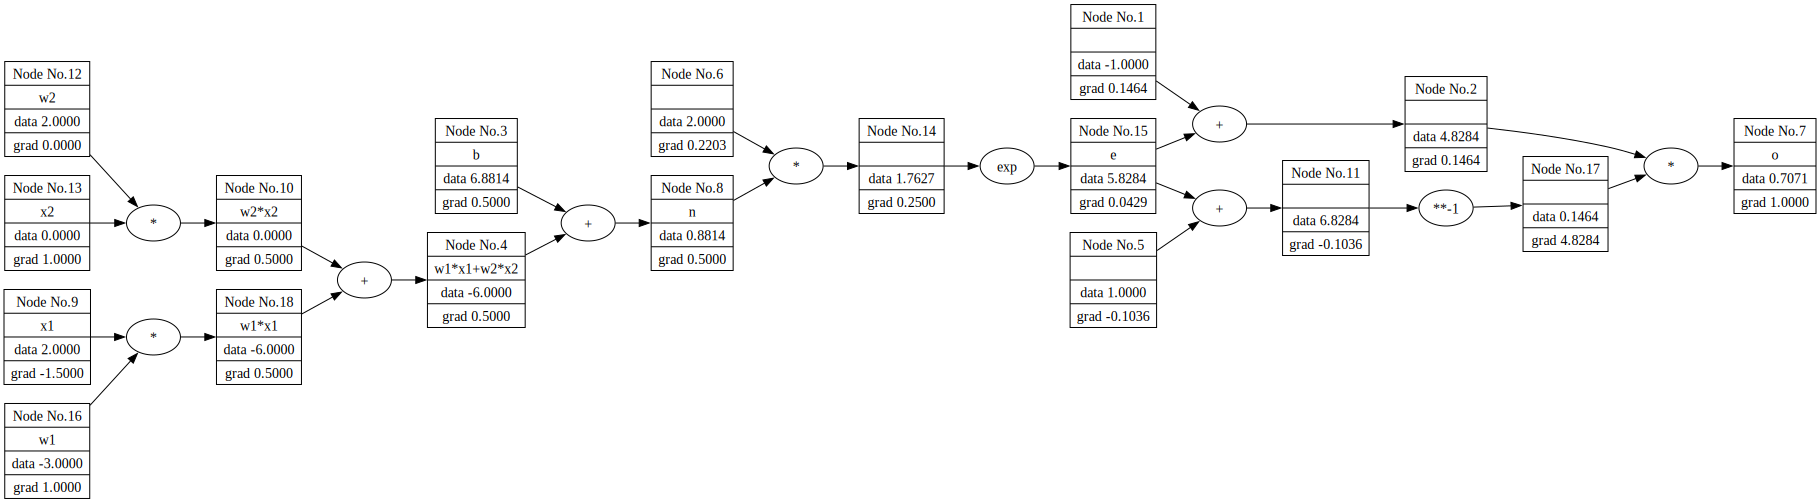

In [39]:
draw_dot(o)


<!-- x2.grad=w2.data * w2x2.grad
w2.grad=x2.data * w2x2.grad
x1.grad=w1.data * w1x1.grad
w1.grad=x1.data * w1x1.grad
 -->




In [229]:

class Neuron:
    def __init__(self,nin):
        self.w=[Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b=Value(random.uniform(-1,1))
    def __call__(self,x):
       out= sum((wi*xi for wi,xi in zip(self.w,x)),self.b)
       o=out.tanh()
       return o
    def parameters(self):
        return self.w+ [self.b]
        

class Layer:
    def __init__(self,nin,nout):
        self.neurons=[Neuron(nin) for _ in range(nout)]
    def __call__(self,x):
      outs=[n(x)  for n in self.neurons]
      return outs[0] if len(outs)==1 else outs
    def parameters(self):
        return [p for neurons in self.neurons for p in neurons.parameters()]
class MLP:
    def __init__(self,nin,nout):
       sz=[nin]+nout
       self.mlp=[Layer(sz[i],sz[i+1]) for i in range(len(nout))]
    def __call__(self,x):
        for ele in self.mlp:
            x=ele(x)
        return x
    def parameters(self):
        return[ p for layers in self.mlp for p in layers.parameters()]
            


In [240]:
n=MLP(3,[4,4,1])

In [238]:
xs=[
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0]
]
ys=[1.0,-1.0,-1.0,1.0]


In [247]:
for k in range(400):
    #forward pass
    ypred= [n(x) for x in xs]
    loss=sum((yut-ygt)**2 for yut ,ygt in zip(ypred,ys))
    #backward pass
    for p in n.parameters():
        p.grad=0.0
    loss.backward()

    #update
    for p in n.parameters():
       p.data+=-0.05*p.grad

    print(k,loss.data)

    
    

0 0.0007393952457624033
1 0.0007387212242126345
2 0.0007380483962201532
3 0.0007373767586556001
4 0.0007367063084004678
5 0.0007360370423470825
6 0.0007353689573985018
7 0.0007347020504685222
8 0.0007340363184815866
9 0.000733371758372775
10 0.0007327083670877308
11 0.0007320461415826478
12 0.0007313850788241969
13 0.0007307251757894656
14 0.0007300664294659876
15 0.0007294088368516114
16 0.0007287523949544973
17 0.0007280971007930775
18 0.0007274429513960213
19 0.0007267899438021334
20 0.0007261380750603801
21 0.000725487342229817
22 0.0007248377423795284
23 0.0007241892725886334
24 0.0007235419299461836
25 0.0007228957115511755
26 0.000722250614512461
27 0.0007216066359487459
28 0.0007209637729885108
29 0.000720322022770014
30 0.000719681382441202
31 0.0007190418491597078
32 0.0007184034200927918
33 0.0007177660924172996
34 0.0007171298633196247
35 0.0007164947299956804
36 0.0007158606896508436
37 0.0007152277394999052
38 0.0007145958767670667
39 0.0007139650986858702
40 0.0007133354

In [248]:
ypred

[Value(data=0.9892546739608188),
 Value(data=-0.9918729318836339),
 Value(data=-0.9852432460190421),
 Value(data=0.9881048764117796)]